In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Seaborn advanced settings

sns.set(style='ticks',          # 'ticks', 'darkgrid'
        palette='colorblind',   # 'colorblind', 'pastel', 'muted', 'bright'
        #palette=sns.color_palette('Accent'),   # 'Set1', 'Set2', 'Dark2', 'Accent'
        rc = {
           'figure.autolayout': True,
           'figure.figsize': (14, 8),
           'legend.frameon': True,
           'patch.linewidth': 2.0,
           'lines.markersize': 6,
           'lines.linewidth': 2.0,
           'font.size': 20,
           'legend.fontsize': 20,
           'axes.labelsize': 16,
           'axes.titlesize': 22,
           'axes.grid': True,
           'grid.color': '0.9',
           'grid.linestyle': '-',
           'grid.linewidth': 1.0,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'xtick.major.size': 8,
           'ytick.major.size': 8,
           'xtick.major.pad': 10.0,
           'ytick.major.pad': 10.0,
           }
       )

plt.rcParams['image.cmap'] = 'viridis'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data cleaning

- Data in ISO-8859-1
    - Detected with chardet (has to be run over bigger sample, after 10000 lines outputs ASCII)
    - Transformed to UTF-8 using codecs
- Semicolons used as delimiters but original file contains amp; instead of &
- Manually fixed few lines with different length
- Users dataset contains addresses in format town;state;country, but data are inconsistent, users probably wrote it instead from selecting from a list. It is possible to clean it, but it would take some time so only age is in the cleaned dataset.

In [ ]:
books = pd.read_csv("/content/drive/MyDrive/Books.csv", sep=";")

users = pd.read_csv("/content/drive/MyDrive/Users.csv", sep=";")

ratings = pd.read_csv("/content/drive/MyDrive/Ratings.csv", sep=";")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['User-ID', 'ISBN', 'Rating']


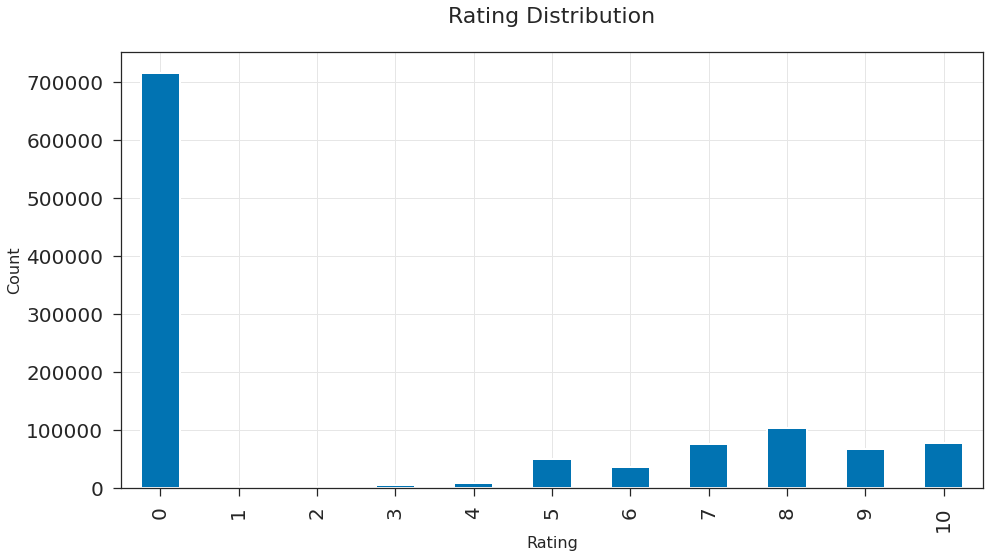

In [ ]:
import matplotlib.pyplot as plt
print(list(ratings.columns))
plt.rc("font", size=15)
ratings.Rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
books.head()

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


In [ ]:
users.head()

,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN


In [ ]:
ratings.head()

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


There are no relevant data about books or users, I will have to use something basic as nearest neighbours, detect the most similar users and recommend books which they read but predicted user did not.

In [ ]:
# Group by and create basic additional users
user_groupby = ratings.groupby("User-ID")
book_groupby = ratings.groupby("ISBN")
average_user_rating = user_groupby["Rating"].mean()
number_of_ratings_by_user = user_groupby["Rating"].count()
average_book_rating = book_groupby["Rating"].mean()
number_of_book_ratings = book_groupby["Rating"].count()

average_user_rating.name = "avg_rating"
number_of_ratings_by_user.name = "N_ratings"
average_book_rating.name = "avg_rating"
number_of_book_ratings.name = "N_ratings"

In [ ]:
# Merge with original dataframes
users = users.join(number_of_ratings_by_user, on="User-ID")
users = users.join(average_user_rating, on="User-ID")
books = books.join(number_of_book_ratings, on="ISBN")
books = books.join(average_book_rating, on="ISBN")

users["N_ratings"] = users["N_ratings"].fillna(0)
books["N_ratings"] = books["N_ratings"].fillna(0)

users["N_ratings"] = users["N_ratings"].astype("int64")
books["N_ratings"] = books["N_ratings"].astype("int64")

# EDA

In [ ]:
print(f"Out of {users.shape[0]} users only {users['N_ratings'].gt(0).sum(axis=0)} rated at least 1 book.")
print(f"Only {users['N_ratings'].gt(1).sum(axis=0)} rated at least 2 books.")
print(f"Only {users['N_ratings'].gt(9).sum(axis=0)} rated at least 10 books.")
print(f"Most active user rated {users['N_ratings'].max()} books.")
print()
print(f"Out of {books.shape[0]} books only {books['N_ratings'].gt(0).sum(axis=0)} are rated at least once.")
print(f"Only {books['N_ratings'].gt(1).sum(axis=0)} have at least 2 ratings.")
print(f"Only {books['N_ratings'].gt(9).sum(axis=0)} have at least 10 ratings.")
print(f"Most rated book was rated {books['N_ratings'].max()} times.")

Out of 278859 users only 99053 rated at least 1 book.
Only 43385 rated at least 2 books.
Only 12306 rated at least 10 books.
Most active user rated 13602 books.

Out of 271379 books only 270171 are rated at least once.
Only 124513 have at least 2 ratings.
Only 17480 have at least 10 ratings.
Most rated book was rated 2502 times.


In [ ]:
users[users["N_ratings"].gt(0)].describe()

,N_ratings,avg_rating
count,99053.000000,99053.000000
mean,10.935479,4.393597
std,91.056053,3.411184
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,4.600000
75%,4.000000,7.500000
max,13602.000000,10.000000


The most popular book series ever (info from Goodreads) is Harry Potter. The first book in the series is [the most rated book](https://www.goodreads.com/list/show/35080.One_Million_Ratings_) (with 6.1 million ratings) and the last book is almost the book with [the best average rating](https://www.goodreads.com/list/show/10198.Books_With_a_Goodreads_Average_Rating_of_4_5_or_higher_and_With_At_Least_100_Ratings) (4.62 out of 5; you can find better up to 4.75, but not with two millions of ratings).

Lets see what are the most popular books and how does Harry Potter stand out.

In [ ]:
# Get the most rated book in the dataset
books[books["N_ratings"] == books["N_ratings"].max()]

,ISBN,Title,Author,Year,Publisher,N_ratings,avg_rating
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,2502,1.019584


With average rating 1 out of 10 (where 0 is minimum), there is probably a reason why we have never heard of Wild Animus by Rich Chapero.

In [ ]:
# Get top 20 best rated books in our dataset
books.loc[books["N_ratings"] > 20].sort_values(by="avg_rating", ascending=False).head(20)

,ISBN,Title,Author,Year,Publisher,N_ratings,avg_rating
3028,1844262553,Free,Paul Vincent,2003,Upfront Publishing,54,7.962963
27557,8445071416,El Hobbit,J. R. R. Tolkien,1991,Minotauro,23,7.478261
1101,0060256672,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,1974,HarperCollins,33,7.121212
16191,0060248025,Falling Up,Shel Silverstein,1996,HarperCollins,38,6.921053
1763,0395177111,The Hobbit (Leatherette Collector's Edition),J. R. R. Tolkien,1973,Houghton Mifflin Company,24,6.791667
10288,0553274325,Johnny Got His Gun,Dalton Trumbo,1983,Bantam Books,32,6.750000
15179,0836221362,It's A Magical World: A Calvin and Hobbes Coll...,Bill Watterson,1996,Andrews McMeel Publishing,28,6.642857
5432,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999,Scholastic,170,6.611765
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,194,6.541237
21546,1563890119,"Preludes and Nocturnes (Sandman, Book 1)",Neil Gaiman,1993,DC Comics,27,6.481481


[Free by Paul Vincent](https://www.goodreads.com/book/show/8580970-free), the book with the highest average rating is almost unknown on Goodreads (with only 24 ratings and average rating 3.29 out of 5). Shel Silverstein's books are poetry for children.

The proof that the dataset is correlated with real world data is that Harry Potter books, Hobbit, Narnia, Discworld and King's and Gaiman's books place in top twenty books. This is what I would expect if there were much more data as everybody at least heard those names.

However, there is a problem. We do not have ratings for books but for editions of books. That means that if we now make a model for recommending books, it will recommend editions instead of books. Without another database linking Edition with ISBN, we can not see, what is really the most favourite book, how many times it was rated etc. (and these seem as important features to me).

Maybe, recommending editions instead of books will not be that bad, as people probably did not read all the editions of Harry Potter and the Sorcerer's Stone. I would guess they read only a single edition of every book in the series, so there will be some distance between users. Plus, if somebody read the spanish edition, it is possible that the model will recommend spanish edition as well. We will see.

Next, just check how many Harry Potter books there are:

In [ ]:
# Get all Harry Potter books and editions written by Rowling
books[books["Title"].str.contains("Harry Potter") & books["Author"].str.contains("Rowling")]

,ISBN,Title,Author,Year,Publisher,N_ratings,avg_rating
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,571,4.900175
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,168,6.363095
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,351,4.729345
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,197,6.467005
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,194,6.541237
...,...,...,...,...,...,...,...
234626,0439294827,Harry Potter and the Sorcerer's Stone: A Delux...,J. K. Rowling,2001,Scholastic,2,9.000000
237878,3895849618,Harry Potter und der Gefangene von Askaban. So...,Joanne K. Rowling,2002,Dhv der HÃ¶rverlag,1,7.000000
251249,847888663X,Harry Potter y El Caliz de Fuego,J. K. Rowling,2001,Lidiun,0,NaN
257280,043955490X,Harry Potter and the Goblet of Fire (Harry Pot...,J. K. Rowling,2003,Arthur A. Levine Books,1,10.000000


Ninety editions of heptalogy. There is also a lot different inputs in Author column like: "J. K. Rowling", "Joanne K. Rowling", "J.K.Rowling", "Rowling J K" and we do not have a database connecting all different names of a single author.

# KNN model - recommend similar book

Find the most similar book (using user-recommendation vectors) and recommend it.

In [ ]:
ratings["Rating"] = ratings["Rating"].astype("int8")

In [ ]:
print(ratings)

         User-ID         ISBN  Rating
0         276725   034545104X       0
1         276726   0155061224       5
2         276727   0446520802       0
3         276729   052165615X       3
4         276729   0521795028       6
...          ...          ...     ...
1149775   276704   1563526298       9
1149776   276706   0679447156       0
1149777   276709   0515107662      10
1149778   276721   0590442449      10
1149779   276723  05162443314       8

[1149780 rows x 3 columns]


In [ ]:
pd_matrix = pd.merge(books.loc[books["N_ratings"] > 20, "ISBN"], ratings).drop_duplicates()


In [ ]:
pd_matrix

,ISBN,User-ID,Rating
0,0399135782,8,0
1,0399135782,11676,9
2,0399135782,29526,9
3,0399135782,36836,0
4,0399135782,46398,9
...,...,...,...
377631,0152012397,240700,7
377632,0152012397,241078,8
377633,0152012397,256167,8
377634,0152012397,259286,8


In [ ]:
# Reshape so that ISBN is row index, User-ID is column index and values are ratings
pd_matrix = pd_matrix.pivot(index='ISBN', columns='User-ID', values='Rating').fillna(0).astype("int8")

In [ ]:
pd_matrix

User-ID,8,9,10,14,16,17,19,26,32,39,42,44,51,53,56,67,69,75,77,78,81,91,95,97,99,114,125,129,132,133,135,144,165,169,176,178,185,193,199,207,...,278663,278672,278683,278692,278694,278698,278723,278724,278732,278740,278755,278760,278767,278769,278771,278773,278774,278781,278782,278784,278786,278796,278798,278800,278807,278813,278818,278819,278824,278828,278831,278832,278836,278838,278843,278844,278846,278849,278851,278854
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000649840X,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0006547834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0006550576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0006550789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0007110928,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8845205118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8845247414,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
884590184X,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Change to sparse matrix if we didn't have enough memory
matrix = csr_matrix(pd_matrix.values)

NameError: ignored

In [ ]:
# Create a model
N_predicted_neighbours = 11
KNN = NearestNeighbors(metric='cosine', n_neighbors=N_predicted_neighbours, n_jobs=-1)

In [ ]:
# Fit the model
KNN.fit(matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                 radius=1.0)

In [ ]:
# Predict
distances, indices = KNN.kneighbors(matrix)

# Note that we do not have to split the data to train, valid and test, as we only need to compute distances between current data



```
# This is formatted as code
```

## Harry Potter check

In [ ]:
print("Index of first Harry Potter book is:", np.where(pd_matrix.index=="059035342X")[0][0])

Index of first Harry Potter book is: 4865


In [ ]:
selected_index = 4865

In [ ]:
# Just check it once again
books.loc[books["ISBN"] == pd_matrix.index[selected_index], "Title"].values[0]

"Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"

In [ ]:
# Predictions

print(f"Because you liked {books.loc[books['ISBN'] == pd_matrix.index[indices[4865][0]], 'Title'].values[0]} you may like:")
print()
for i in range(1, N_predicted_neighbours):
    print(f"{books.loc[books['ISBN'] == pd_matrix.index[indices[4865][i]], 'Title'].values[0]} with distance {distances[4865][i]:.3f}.")

Because you liked Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) you may like:

Harry Potter and the Chamber of Secrets (Book 2) with distance 0.701.
Harry Potter and the Prisoner of Azkaban (Book 3) with distance 0.760.
Harry Potter and the Goblet of Fire (Book 4) with distance 0.828.
Harry Potter and the Goblet of Fire (Book 4) with distance 0.838.
Harry Potter and the Order of the Phoenix (Book 5) with distance 0.852.
Harry Potter and the Prisoner of Azkaban (Book 3) with distance 0.869.
Harry Potter and the Chamber of Secrets (Book 2) with distance 0.875.
The Lost King (Star of the Guardians, Vol 1) with distance 0.902.
Fried Green Tomatoes at the Whistle Stop Cafe with distance 0.904.
Love Story with distance 0.911.


Awesome! I was recommended other books in the series when I read the first book and liked it. 

However, there is the problem I noticed earlier, that I am recommended the same book multiple times just because the model recommends editions not books.

Lets wrap it up and create a recommender function.

In [ ]:
def recommend_similar_book(isbn, indices, ratings_matrix, books_table, N_recommendations=1, distances=None):
    """
    Recommends a book title.
    
    Parameters
    ----------
    ISBN: str
        ISBN of a book a user liked
    indices: np.array
        indices of ratings_matrix as predicted by KNN
    ratings_matrix: pd.DataFrame
        user-book-rating matrix with ratings as values
    N_recommendations: int (default 1)
        How many books to recommend?
    distances: np.array
        How distant are books from each other by KNN?
    """
    # TODO: This should be rather split in separate variables, this reads terribly
    print(f"Because you liked {books_table.loc[books_table['ISBN'] == ratings_matrix.index[indices[isbn][0]], 'Title'].values[0]} you may like:")
    print()
    for i in range(1, 1+N_recommendations):
        if distances:
            print(f"{books_table.loc[books_table['ISBN'] == ratings_matrix.index[indices[isbn][i]], 'Title'].values[0]} with distance {distances[isbn][i]:.3f}.")
        else:
            print(f"{books_table.loc[books_table['ISBN'] == ratings_matrix.index[indices[isbn][i]], 'Title'].values[0]}.")

In [ ]:
recommend_similar_book(4865, indices, pd_matrix, books)

Because you liked Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) you may like:

Harry Potter and the Chamber of Secrets (Book 2).


# KNN model - recommend similar user's favourite book

Find the most similar user and recommend his top rated books that the current user have not read yet.

Lets first prepare data for testing a model. For every user add how many Harry Potter books did they read and what is their average rating. Using KNN the distance between users who liked the series should be low, whereas the distance between users who did like it and those who did not like it should be higher.

In [ ]:
harry_potter_isbns = books.loc[books["Title"].str.contains("Harry Potter") & books["Author"].str.contains("Rowling"), "ISBN"].values
harry_potter_ratings = ratings.loc[ratings["ISBN"].isin(harry_potter_isbns)]

In [ ]:
# Group by and create new features
user_groupby = harry_potter_ratings.groupby("User-ID")
average_user_rating = user_groupby["Rating"].mean()
number_of_ratings_by_user = user_groupby["Rating"].count()

average_user_rating.name = "HP_avg_rating"
number_of_ratings_by_user.name = "HP_N_ratings"

In [ ]:
# Merge with the main dataframe
users = users.join(number_of_ratings_by_user, on="User-ID")
users = users.join(average_user_rating, on="User-ID")

users["N_ratings"] = users["N_ratings"].fillna(0)

users["N_ratings"] = users["N_ratings"].astype("int64")

In [ ]:
# Get some statistics for those users who have read at least one book from the HP series
users.loc[users["HP_N_ratings"].gt(0)].describe()

,N_ratings,avg_rating,HP_N_ratings,HP_avg_rating
count,1494.000000,1494.000000,1494.000000,1494.000000
mean,201.074297,3.916865,1.855422,5.064660
std,585.361399,2.708143,1.436947,4.250286
min,1.000000,0.000000,1.000000,0.000000
25%,7.000000,1.802073,1.000000,0.000000
50%,38.000000,3.486100,1.000000,6.000000
75%,163.750000,5.642787,2.000000,9.000000
max,13602.000000,10.000000,17.000000,10.000000


Hmmm, there are people who read more than 7 different editions, so my earlier guess that people probably read max 7 editions (1 per book in series) is not true.

Given that the average rating is 5 out of 10, there are probably two groups of people, those who really like it and those who do not like it. Lets visualize it!

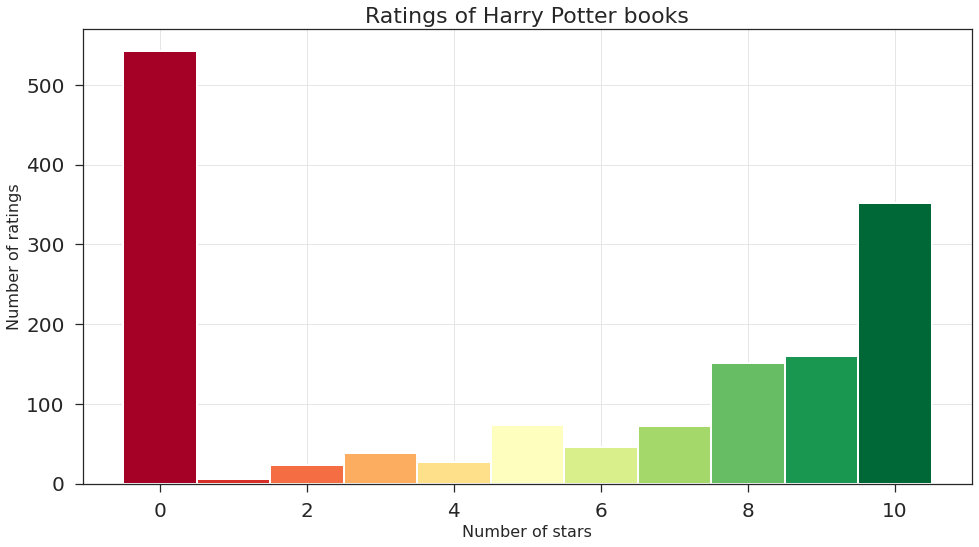

In [ ]:
plt.figure()
# sns.distplot(users.loc[users["HP_N_ratings"].gt(0)]["HP_avg_rating"], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
bins = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]) - 0.5
n, bins, patches = plt.hist(users.loc[users["HP_N_ratings"].gt(0), "HP_avg_rating"], bins=bins)
cm = plt.cm.get_cmap('RdYlGn')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.title("Ratings of Harry Potter books")
plt.xlabel("Number of stars")
plt.ylabel("Number of ratings")
plt.show()

Well... I didn't expect that there will be so many so negative ratings, but lets continue and find out a few persons who read the whole series and didn't like it (if there are any, else take someone who read at least two books and did not like it) and people who liked it. Then we will have some people to test the next model on.

In [ ]:
# Get users who read seven books of the series
users.loc[users["HP_N_ratings"]==7]

# Note that this selection does not have to mean, they have read all parts of the series, just that they rated seven editions.
# Nevertheless, as first testing data, it is probably OK.

,User-ID,Age,N_ratings,avg_rating,HP_N_ratings,HP_avg_rating
253,254,24,314,1.436306,7.0,7.714286
28522,28523,24,397,1.224181,7.0,4.285714
30734,30735,NaN,284,5.887324,7.0,9.571429
88732,88733,NaN,1158,3.395509,7.0,9.428571
175002,175003,33,1670,0.203593,7.0,10.000000
185232,185233,31,2448,1.524918,7.0,1.428571
203074,203075,23,161,2.652174,7.0,8.428571
211425,211426,24,978,1.003067,7.0,4.285714


Awesome, those are exactly people we need. There is one hater, who rated every book, but gave very low rating to each one (I wonder if he had actually read the series or he may also did not understand the rating system), there is only one person who read everything and gave 10 starts to each book and finally there are people who liked it and some who did not.

In [ ]:
# Transform User-ID to the index in our user-book-rating matrix
selected_matrix_indices = [pd_matrix.columns.get_loc(user_ID) for user_ID in users.loc[users["HP_N_ratings"]==7].sort_values(by="HP_avg_rating", ascending=False)["User-ID"].values]

In [ ]:
KNN3 = NearestNeighbors(metric='cosine', n_neighbors=8, n_jobs=-1)

In [ ]:
KNN3.fit(matrix.T[np.ix_(selected_matrix_indices)])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=8, p=2, radius=1.0)

In [ ]:
distances3, indices3 = KNN3.kneighbors(matrix.T[np.ix_(selected_matrix_indices)])

In [ ]:
ind = np.argsort(indices3, axis=1)

In [ ]:
sorted_distances = np.take_along_axis(distances3, ind, axis=1)

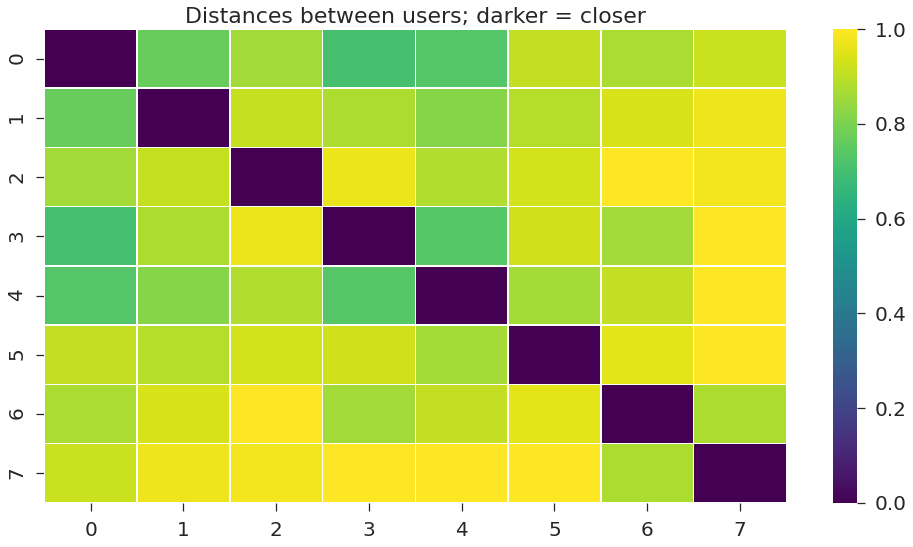

In [ ]:
plt.figure()
ax = sns.heatmap(sorted_distances, linewidth=0.5, cmap="viridis")
plt.title("Distances between users; darker = closer")
plt.show()

This obviously works as well as the last user (who did not like Harry Potter) is the furthest from all other users.

These distances were computed only for eight users, they will be different in reality.

In [ ]:
# Create a model
KNN2 = NearestNeighbors(metric='cosine', n_neighbors=20, n_jobs=-1)

In [ ]:
# Fit
KNN2.fit(matrix.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
# Predict
distances2, indices2 = KNN2.kneighbors(matrix.T)

In [ ]:
# Transform User-ID to the index in our user-book-rating matrix
pd_matrix.columns.get_loc(175003)

34620

In [ ]:
# Get most similar users
indices2[34620]

array([34620, 50133, 45485, 54490, 54030, 21293, 47528, 11514, 37370,
       50365, 48620, 42004, 36599,  1180, 16868, 33699, 33372, 37530,
         876, 36099])

In [ ]:
# Transform back and get User-ID of nearest neighbor
pd_matrix.columns[50133]

252829

In [ ]:
users.loc[users["User-ID"] == 252829]

,User-ID,Age,N_ratings,avg_rating,HP_N_ratings,HP_avg_rating
252828,252829,18,10,10.0,9.0,10.0


Great, the most similar user to our Harry Potter lover is another user who rated more editions than there is HP books with 10 stars. This shows that the model is working, but the problem with edition still persists. If we recommend a favourite book of the most similar user, specifically for this one, it will probably be another HP edition.

In [ ]:
def recommend_favourite_book_of_similar_user(userID, indices, ratings_matrix, users_table, books_table, ratings_table, N_recommendations=1, distances=None):
    """
    Recommends a book title based on favourite books of ten most similar users.
    
    The order of books is following:
    Take the most similar user, sort his books by rating,
    exclude everything the current predicted user already read.
    Output books one by one.
    If there is only a few books from the most similar user and
    we run out of books, take next similar user and output
    his favorite books in a similar fashion.
    
    Parameters
    ----------
    userID: int
        ID of a user we want a recommendation for
    indices: np.array
        indices of ratings_matrix as predicted by KNN
    ratings_matrix: pd.DataFrame
        user-book-rating matrix with ratings as values
    users_table: pd.DataFrame
        Information about users
    books_table: pd.DataFrame
        Information about books
    ratings_table: pd.DataFrame
        Information about ratings
    N_recommendations: int (default 1)
        How many books to recommend?
    distances: np.array
        How distant are books from each other by KNN?
    """
    selected_index = ratings_matrix.columns.get_loc(userID)
    already_read_book_isbns = list(ratings_table.loc[ratings_table["User-ID"] == userID, "ISBN"].values)
    not_read_books = ratings_table.loc[~ratings_table["ISBN"].isin(already_read_book_isbns)]
    books_to_recommend = list()
    for i in range(1,10):
        similar_user_index = indices[selected_index][i]
        similar_user_ID = ratings_matrix.columns[similar_user_index]
        possible_to_recommend = not_read_books.loc[not_read_books["User-ID"] == similar_user_ID]
        possible_to_recommend = possible_to_recommend.sort_values(by="Rating", ascending=False)
        for a, row in possible_to_recommend.iterrows():
            books_to_recommend.append(books_table.loc[books["ISBN"] == row["ISBN"], "Title"].values[0])
            if len(books_to_recommend) > N_recommendations-1:
                break
        if len(books_to_recommend) > N_recommendations-1:
            break
    print(f"Based on users who like similar books as you, you may like:")
    print()
    for book_name in books_to_recommend:
        print(book_name)

In [ ]:
recommend_favourite_book_of_similar_user(175003, indices2, pd_matrix, users, books, ratings, N_recommendations=3, distances=distances2)

Based on users who like similar books as you, you may like:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Ultimate Unofficial Guide to the Mysteries of Harry Potter


# Types of recommendations

- Recommend similar book to a book a user rated high
- Recommend a book rated highly by a similar user (or a group of similar users)
- Recommend a book of a user's highly rated author (if someone likes Pratchett, they will probably like almost all of his books)
- Recommend the topmost highly rated book from all books that user did not read
- Recommend a random book (I guess that some people just do not like to decide and this can be used to collect data about book almost nobody reads)

# What would be ideal

## Additional data possible to mine
Goodreads has an [API](https://www.goodreads.com/api) which is possible to use to get more features. Number of ratings and average rating should definitely be more informative feature than from the current dataset. Goodreads also specifies what genre a book is and also allows users to hashtag any book with any hashtag. These hashtag could also serve as additional info about books if they are properly grouped.

Goodreads features:
- Number of ratings
- Average rating
- Number of stars (it is different if a book always get 3 stars from everybody or if it gets fives and ones)
- How many times was the page with the book visited?
- Number of pages
- Average reading time
- Genre
- Is part of series? How many books does the series have? What is the number of the book in series?
- Hashtag groups
- How many books did the author write?
- Is the author popular? (number of followers)
- Number of editions
- Number of translations 

## Additional ideal data
Ask user what kind of books do they like; ideally have a page with sliders for different kind of books (sci-fi, romance...). Perhaps ask them what kind of book would they want to read next. They could also check a type of recommendations. 

Ideal additional features:
- How much does the user like sci-fi/romance...

# Possible models

With additional features listed above the most transparent model would be lightGBM or a different regression forest as it can output the importance of features. I would guess that a neural network where user and book features are encoded separately would give better results. I would find interesting using a RNN or different NN with memory as the reader's taste changes and it does not make sense to base predictions on books read twenty years ago.